# Computer Vision - Assignment 3 - Feature Extraction and Image Stitching

#### 10 points   |   Due date: April 14, 23:59   |   Submission site: https://pradoposgrado2324.ugr.es/

### Student's Full Name: <mark>Seyedeh Kimia Arfaie Oghani</mark>



<font color='blue'>In this assignment you will learn:

<font color='blue'>a) to detect interest points using the Harris Corner Detector (Exercise 2) and a multi-scale approach to detect blobs using the Laplacian of Gaussian (Exercise 1).

<font color='blue'>b) to find correspondences between the keypoints from two images using descriptors (SIFT and Haralick) (Exercise 3).

<font color='blue'>c) to compose a rectangular mosaic/panorama from a bunch of images using homographies (Exercise 4).

In [71]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys,os
%cd '/content/drive/My Drive'
get_image = lambda route: os.path.join('/content/drive/MyDrive/images/', route)
import numpy as np
from matplotlib import pyplot as plt
import cv2

Mounted at /content/drive
/content/drive/My Drive


In [72]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [73]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [74]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

In [75]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

The functions for Gaussian Masks, Convolution and Image Derivaties are written from Assignment 1:

In [76]:
def GaussFunc(x,sigma):
    return np.exp(-(x**2/(2*sigma**2))) # I computed 1D  Gaussian function, but ignored constant c

def GaussDeriv1Func(x,sigma):
    return (-x/(sigma**2))*GaussFunc(x, sigma) # Computed First Derivative of 1D Gaussian function from previous step

def GaussDeriv2Func(x,sigma):
    return ((x**2-sigma**2)/(sigma**4))*GaussFunc(x, sigma) # Computed Second Derivative of 1D Gaussian function (took one more derivative from the first derivative)

def gaussianMask1D(sigma=0, sizeMask=0, order=0): # Function to compute Gaussian Mask, 1st and 2nd derivative
    if sizeMask==0: # Calculate sizeMask for the case when sigma is provided
        sizeMask = int(2*(3*sigma)+1) # (T-1)/2=3*sigma -> T=2*(3*sigma)+1, where T is a sizeMask
    elif sigma==0: # Calculate sigma for the case when sizeMask is provided
        sigma = (sizeMask-1)/6 # As (T-1)/2=3*sigma from the slide 23

    # Created a 1D mask centered at 0.

    k = np.floor(3*sigma)
    x = np.arange(-k, k+1) # added +1, as the the second border is not included in this function: numpy.arange([start, ]stop, [step, ]dtype=None, *, like=None)

    # Calculate Guassian mask, 1st and 2nd deriv depend on the order
    if order==0:
        mask=GaussFunc(x, sigma)  # Calculated Gaussian mask with previously created function
        # Normalized mask: Gaussian kernel is smoothing, so we need to divide by the sum
        mask /= np.sum(mask)
    elif order==1:
        mask=GaussDeriv1Func(x, sigma)  # Calculated first derivative mask with previously created function
        # Normalized mask: 1st Derivative kernel is Differentiating, so we need to multuply by sigma (this way we recover the amplitude)
        mask = mask*sigma
    elif order==2:
        mask=GaussDeriv2Func(x, sigma)  # Calculated second derivative mask with previously created function
        # Normalized mask: 2nd Derivative kernel is Differentiating, so we need to multuply by sigma**2 (in order to recover the response and avoid shrinking)
        mask = mask*sigma**2

    return mask, x

def my2DConv(im, sigma, orders):
    ddepth=cv2.CV_64F # For visualization purposes
    maskG,_=gaussianMask1D(sigma, order=0) # Calculate 1D Gaussian mask
    maskDG,_=gaussianMask1D(sigma, order=1) # Calculate 1st order derivative
    mask2DG,_= gaussianMask1D(sigma, order=2) # Calculate 2nd order derivative
    # Ensure the masks are in the correct format (1D numpy arrays), Masks should be 1D arrays to be used by sepFilter2D
    # This was done due to an error that was happening regarding the format of the masks
    maskG = np.array(maskG, dtype=np.float64).flatten()
    maskDG = np.array(maskDG, dtype=np.float64).flatten()
    mask2DG = np.array(mask2DG, dtype=np.float64).flatten()

    if orders==[0,0]: # Gaussian smoothing
      # Smooth in both directions
      return cv2.sepFilter2D(im,ddepth,maskG,maskG)
    elif orders==[1,0]: # First derivative in X
      # Smooth in Y direction, differentiate in X direction
      return cv2.sepFilter2D(im,ddepth,maskDG,maskG)
      # and MaskG as vertical 1D Gaussian kernel.
    elif orders==[0,1]: # First derivative in Y
      # Smooth in X direction, differentiate in Y direction
      return cv2.sepFilter2D(im, ddepth, maskG, maskDG)
    elif orders == [2, 0]: # Second derivative in X
      # Smooth in Y direction, differentiate twice in X direction
      return cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
    elif orders == [0, 2]: # Second derivative in Y
      # Smooth in X direction, differentiate twice in Y direction
      return cv2.sepFilter2D(im, ddepth, maskG, mask2DG)
    else:
      print('error in order of derivative')

# <font color='blue'>**Exercise 1:** Multi-scale blob detection using the Laplacian of Gaussian (2 points)

<font color='blue'> Students must implement a multiscale blob detector in Python that, based on successive applications of Laplacian of Gaussian (LoG) filters, allows them to identify interest points/regions. The process to follow is detailed below:

> <font color='blue'>1) use the following sigmas to create the corresponding scales: 11 values starting from $\sigma_0 = 0.5$ and increase $\sigma$ by a factor of 1.5. In other words, $\sigma=[0.5, 0.75, 1.125, 1.687, 2.531, 3.796, 5.695, 8.542, 12.814, 19.221, 28.832]$. Remember to convolve the image with scale-normalized LoG.

> <font color='blue'>2) Find maxima of squared Laplacian response in scale-space. Select the local maximum corresponding to a neighborhood $3\times3\times3$, where the central pixel of this volume would be the position to evaluate. That is, each pixel is compared with its 26 neighbors and saved if it is a maximum. The function `maximum_filter` from `scipy.ndimage` may be useful here. Along with this, also use a $\textit{threshold}$ to limit the number of blobs detected to around 1000 points.

> <font color='blue'>3) Draw the detected blobs as circles centered on the identified Cartesian coordinates, and radius proportional to the scale at which the corresponding blob was detected.

<font color='blue'>The process is visually shown on slide 63 of https://pradogrado2324.ugr.es/pluginfile.php/234073/mod_folder/content/0/3.3.BoW_Blobs.pdf

**Exercise 1**

in this part we will perform blob detection. We can define blobs as regions that contrast with what is around them. In detecting blobs, we have to keep in mind that the filters that will be used in this section, are chosen based on the fact that filters tend to produce a strong response to patterns that look like them.

The idea in this process is to convolve the image with a "blob filter" at multiple scales, in order to detect blobs in different scales, then we have to find the extrema of the filter response in the scale space.

In order to detect blobs in an image, we will use Laplacian of Gaussian filters which looks similar to the blobs we want to detect in an image. We are looking for light blobs on dark backgrounds (minima in the LoG response) and dark blobs on light backgrounds (maxima in the LoG response).

First, we define the sigmas that we want to find the LoG responses in; these sigmas will give us different responses in different scales, which later we want to find their maxima and minima in.

We calculated the squared Laplacian response, using my my2DConv function from assignment 1 (convolving the image with scale-normalized laplacian in several spaces). We have to keep in mind that this function is already scale-normalized, as it can be seen in the gaussianMask1D function; the mask for order of 2 is multiplied by sigma.^2. We know this is crucial, as we want to keep the responses the same (scale-invariant) as the sigma increases.


Then the squared LoG responses were shown in different scales. We see that as sigma increases, we know the Gaussian filter becomes wider, which means the image is smoothed more and details are lost. At smaller sigmas, the filter is more sensitive to fine details, which we can say is effective for detecting smaller blobs. As we increase the sigma, in higher values, the images get smoother, making larger blobs in the image to be more evident.

In [77]:
# Getting the sigma values
sigma0 = 0.5 # First sigma

# Initialize the list with the first sigma value
sigmas = [sigma0]

# Loop to generate the next 10 sigma values, increasing each by a factor of 1.5
for _ in range(10):
    sigmas.append(sigmas[-1] * 1.5)

print(sigmas)

[0.5, 0.75, 1.125, 1.6875, 2.53125, 3.796875, 5.6953125, 8.54296875, 12.814453125, 19.2216796875, 28.83251953125]


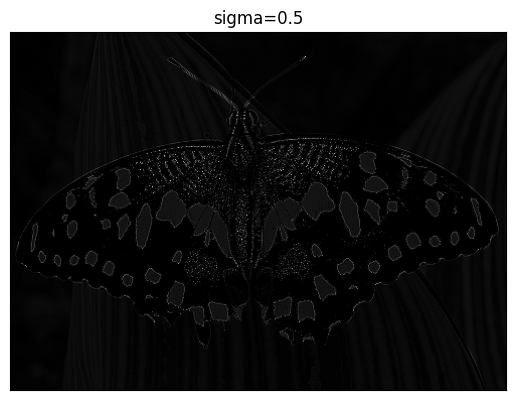

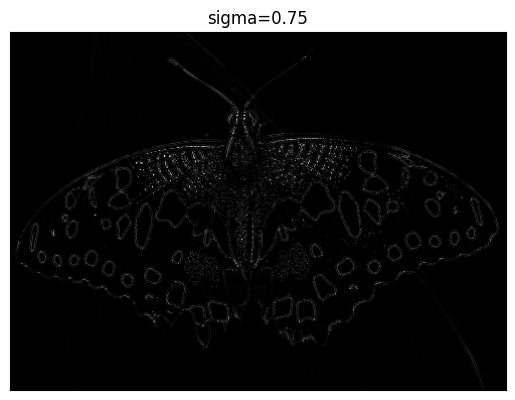

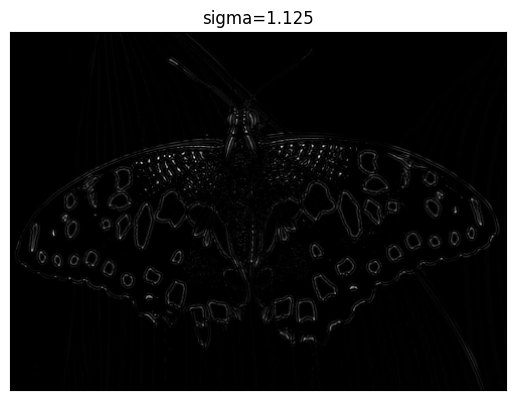

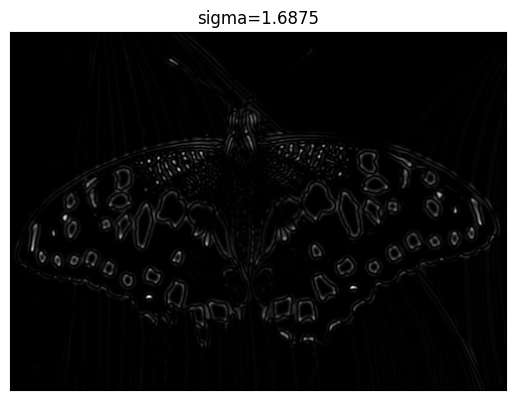

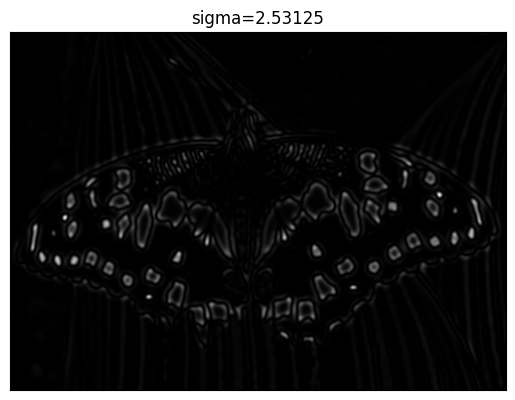

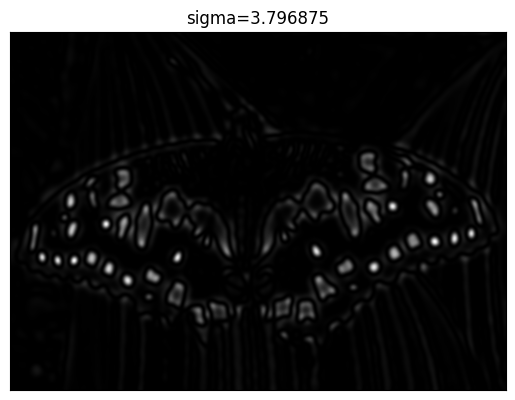

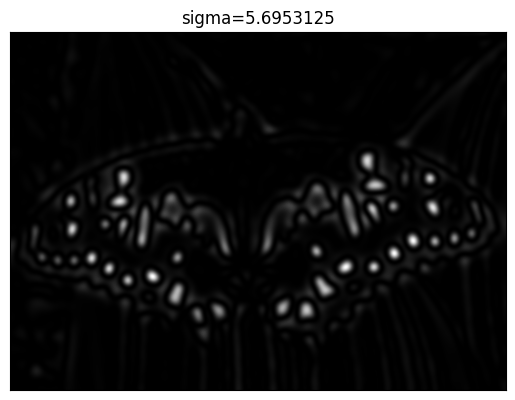

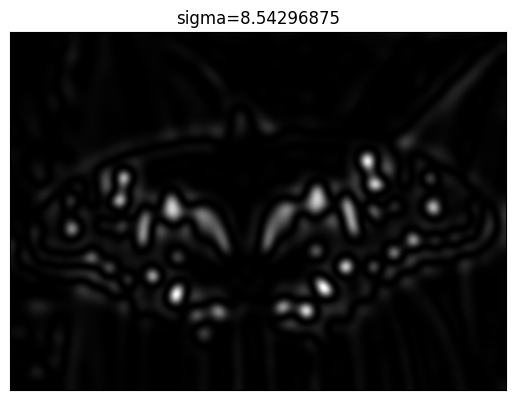

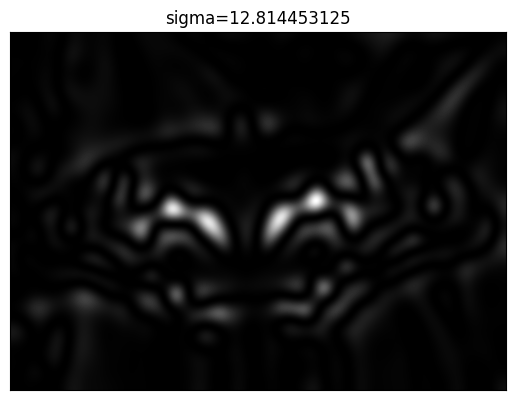

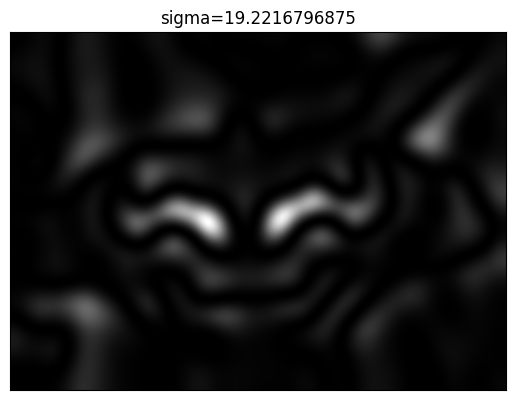

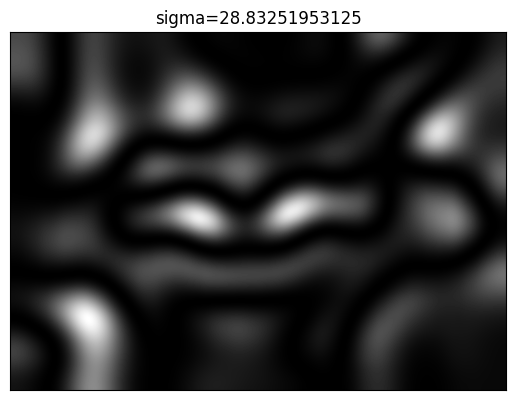

In [8]:
# Calculating Squared scaled normalized LoG responses.
im=cv2.imread(get_image('butterfly.jpg'),0)

vim = [] # List of LoG images

for sigma in sigmas:
    LoG = np.square(my2DConv(im, sigma, [2, 0]) + my2DConv(im, sigma, [0, 2]))
    vim.append(LoG)


# Loop through each scale and show the corresponding image
for i in range(len(sigmas)):
  displayIm(vim[i],f"sigma={sigmas[i]}", factor=1)


Next, we will find the maxima of squared Laplacian response in scale scape. The reason we square the Laplacian response is that this response can have negative and positive values, and we know that minima responses are also important for us (light blobs on dark backgrounds); therefore, in order to not lose these negative minima, we square the response, and now we just find the maxima of the squared Laplacian response.

First, we stack all the images on each other to create our 3D scale-spatial space.

Then, through the maximum_filter function, we can find the local maxima in this scale-spatial space in a neighborhood of 3x3x3.

**Applying the 3D Maximum Filter:**

 maximum_filter(scale-spatial space, size=(3, 3, 3)) computes the maximum value in a 3x3x3 neighborhood for every point in the 3D array (which is our space). This means for each volume pixel, the function compares it against its neighbors in all directions (across scales and spatial dimensions). When the maximum_filter is applied to the scale-spatial space representation, each pixel is replaced with the maximum value within its 3x3x3 neighborhood across the scale-spatial space.

Now, we have images (max_filtered variable) that contains the maximum values in each scale. Next, we want to find the maximum values in each scale with its corresponding scale.

**Comparison Against Filtered Output:**

The code line is_maxima = (scale_space == max_filtered) performs an element-wise comparison between the original scale-spatial space and the maximum-filtered. This result in a boolean array where True values indicate that the original volume pixel value was the highest in its 3x3x3 neighborhood, hence identifying it as a local maximum.
this comparison checks if the original value at a given position matches the maximum value within its neighborhood.
True Values: In the is_maxima array, True means that the corresponding volume pixel in the scale-spatial space is a local maximum. Meaning, it was not surpassed by any of its neighbors, which implies that it's a potential candidate for a significant blob in the image.
False Values: Conversely, False indicates that the pixel was not a local maximum, meaning there was at least one volume pixel in its neighborhood that had a higher value. Meaning, these are not candidates for blobs.


**Thresholding**

After identifying the local maxima, we apply a threshold to filter out less significant maxima to limit the number of blobs detected.:
A percentile-based threshold is used here to select only the most significant local maxima. This helps in focusing on the most prominent blobs. We then created a new boolean array thresholded_maxima that keeps only those local maxima that have a value higher than the calculated threshold. Then by finding where they are (using np.argwhere function) we find their location in the image.




In [13]:
from scipy.ndimage import maximum_filter

# Stack the images to form a 3D space
scale_space = np.stack(vim, axis=0) # Now we are in the scale-spatial space

# Apply a 3D maximum filter to identify local maxima
max_filtered = maximum_filter(scale_space, size=(3, 3, 3))


# Identifying the Local Maxima, comparison against the original scale_space
is_maxima = (scale_space == max_filtered)

# Applying the threshold

# Use a high percentile of the data as the threshold.
threshold_value = np.percentile(scale_space[is_maxima], 95)

# Apply the threshold to the boolean array of local maxima
thresholded_maxima = is_maxima & (scale_space > threshold_value)

# Extracting the positions of the maxima after thresholding
maxima_positions = np.argwhere(thresholded_maxima)

# The 'maxima_positions' array will have rows of [scale_index, y_position, x_position] for each local maximum found above the threshold

# Check the distribution of scales -> in which scales the most important blobs are
unique_scales = np.unique(maxima_positions[:, 0])  # The first column has the scale indices
print(f"Unique scales found: {unique_scales}")

# Print the number of positions found
num_positions_found = maxima_positions.shape[0]
print(f"Number of blobs found: {num_positions_found}")

Unique scales found: [ 0  2  3  4  5  6  7  8  9 10]
Number of blobs found: 889


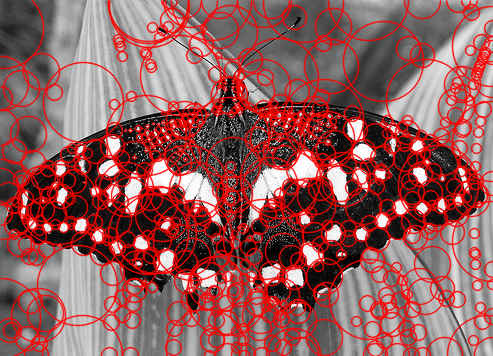

In [14]:
# Drawing circles around detected blobs

from google.colab.patches import cv2_imshow

newim = np.stack((im,)*3, axis=-1)

colorLine=(0,0,255)

lineThickness=1

# Looping through the detected blobls, maxima_positions consists of [scale_index, y_position, x_position]
for scale_index, y, x in maxima_positions:
    sigma_at_maxima = sigmas[scale_index]  # Get the sigma value corresponding to the scale index
    radiusCircle = int(np.sqrt(2) * sigma_at_maxima)  # Calculate the radius proportional to sigma
    centerPoint = (x, y)

    # Draw the circle on the color image, lineType=cv2.LINE_AA prevents from aliasing of the circle line
    cv2.circle(newim,centerPoint,radiusCircle,colorLine,lineThickness, lineType=cv2.LINE_AA)

# show the image
cv2_imshow(newim)


**Discussion**

Looking at the image, we see the varying sizes of the circles, indicating blobs of different scales that have been detected. We see there is a high concentration of detected blobs on the wings of the butterfly, which is expected as the wings contain many contrasting patterns and that create a significant response in the LoG filter.

# <font color='blue'>**Exercise 2:** Harris Corner Detector (3 points)

<font color='blue'>Write the Python code necessary to implement the detection of the stronger 100-150 Harris points in an image. The steps to implement the Harris corner detector are the following: \


> <font color='blue'>a) Set the derivative ($\sigma_D$) and integration scales ($\sigma_I$) to 1.5 and 2.25, respectively. Other sigma values can also be employed if the student considers that it improves performance.



> <font color='blue'>b) Compute the image derivatives.

> <font color='blue'>c) Compute the three terms of the second moment matrix ($SMM$) at each pixel. To do it, apply convolution with a Gaussian mask with $\sigma_I$.

> <font color='blue'>d) Compute the Harris value at each pixel of the image.

> <font color='blue'>e) Apply Non-Maxima Suppression by using the function `corner_peaks()` (https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.corner_peaks) from the module `skimage.features`. The student must select a suitable `min_distance` (`minimal allowed distance separating peaks`), and a suitable response threshold in the Harris Map to just keep the number of keypoints we need (100-150). The output will be a list of $(x,y)$ coordinates. Extract the values in these coordinates and create a list of vectors $(x,y,value)$.

> <font color='blue'>f) Compute the main orientation for each point. This is done by smoothing both derivative images with a sufficiently large sigma ($\sigma=3$) and computing the orientation of the gradient at those points.

> <font color='blue'>d) Create a list of KeyPoints using the selected points. A KeyPoint is a vector including $(x,y,scale,orientation)$. A KeyPoint is an OpenCV's structure (`cv2.KeyPoint`), associated to each detected region,  necessary to call OpenCV feature extractor algorithms.

> <font color='blue'>e) Draw the keypoints on the image using the function `drawKeyPoints()` (https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920), and flags `cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`.


**Exercise 2**

In this exercise, we want to detect corners with Harris corner detector. In this method, we use image derivatives to find corners; as corners are strong positive values along one edge, and a strong negative value along the other edge. In order to compute image derivatives the my2DConv functions with orders of [1,0] and [0,1] were used.

Theoretically, in the Harris method, a small window will shift over a patch of an image (for instance by u,v), and calculate the sum of squared differences between the pixels in the window before and after shifting. If the error is high for all possible directions of the window (all u, vs), there is a possible corner. Through Taylor series expansion of I, we can approximate this error as:

E(u,v) = Au^2 + 2Buv + Cv^2

A = sum(Ix^2), B = sum(Ix*Iy), C = sum(Iy^2)

In matrix form, it can be written as bellow:

E(u,v) = [u v]*[A B; B C]*[u; v]

The [A B; B C] matrix is known as the 2nd moment matrix. The summing is over the pixels in the window.

In practice, using this simple window doesn't work well; instead, we'll weight each derivative in the 2nd moment matrix based on its distance from the center pixel. This can be done using a Gaussian window function, where pixels closer to the center have a higher weight and those further away have a lower weight. That's why in the HarrisMap function in the following section, fisrt we calculate product and square of the derivatives which will give us three images (dx^2, dy^2 and dxdy) and then we used the my2DConv function on each one of them, to convolve them with a Gaussian filter with the indicated sigma (orders of [0,0]).

In the end, the cornerness value was calculated which describes the likelihood that a given pixel in the image is part of a corner. The "cornerness" at each pixel is then calculated using a formula that involves the eigenvalues λ1 and λ2 of the second moment matrix. These eigenvalues represent the magnitude of the gradients in the corresponding principal directions. The formula is as bellow:

R = λ1λ2/(λ1 + λ2), which can be expressed in terms of the determinant and trace of the matrix H as:

R = det(H)/trace(H)

det(H) is the determinant of H, calculated by detH = Ixx * Iyy - Ixy^2.

trace(H) is the trace of H, calculated by
traceH = Ixx + Iyy.

In [78]:
# Compute image derivatives
def derivatives(im,sigmaD):
  im=im.astype(np.float32)
  dx = my2DConv(im,sigmaD,orders=[1,0]) # along x direction
  dy = my2DConv(im,sigmaD,orders=[0,1]) # along y direction
  return dx,dy

# Smooth the three images with Gaussian smoothing
# Compute Harris-criterium Map
def HarrisMap(dx,dy,sigmaI):

  # Compute the three terms of the SMM at each pixel.
  Ixx = my2DConv(dx**2, sigmaI, orders=[0,0])
  Iyy = my2DConv(dy**2, sigmaI, orders=[0,0])
  Ixy = my2DConv(dx*dy, sigmaI, orders=[0,0])

  detH = Ixx * Iyy - Ixy ** 2

  traceH = Ixx + Iyy

  HMap= detH/traceH

  return HMap


**Non-maxima Suppression**

The last procedure in this method is non-maxima suppression. This method slides a window over the image, and at each point if the central pixel is the maximum value in the window, we keep it, otherwise it is removed. This helps us to get to one pixel as the maximum response; meaning to identify the highest corner response in a local neighborhood providing a precise corner.

We use corner_peaks function to do this. This function takes the harris map we made and a min_distance parameter. This parameter determines the minimum number of pixels separating corner peaks. For smaller images or when you expect corners to be close to each other, you might choose a smaller min_distance. For our image, later i used 5. This function will give us the coordinates of these peaks, and then we retrieve their corresponding values. This function also takes a threshold parameter, which is the absolute threshold for the Harris response values. Any pixel in the harrisMap with a value below this threshold will be rejected as a corner candidate. This means that only the pixels with "cornerness" values above this threshold will be considered in the non-maxima suppression process and potentially marked as corners.

In [79]:
from skimage.feature import corner_peaks

def NonMaximaSuppression(harrisMap, min_distance, threshold=None):

  points = corner_peaks(harrisMap, min_distance, threshold_abs=threshold)

  # Extract the Harris response values at the detected corner locations

  values = harrisMap[points[:, 0], points[:, 1]]

  return points, values

Next, we can calculate the main orientation of each point. We did this by. smoothing both of the derivatives (dx and dy) using my2DConv function with sigma of 3. Later we will give this angle to the cv2.KeyPoint class, which expects the angle to be in degrees; the np.arctan2 function in NumPy returns the angle in radians. Therefore, we converted it to degrees in this function too.

Next, we created the KeyPoints function that gets the coordinates, theta and scale, and using cv2.KeyPoint creates a keypoint from them which is a vector including (𝑥,𝑦,𝑠𝑐𝑎𝑙𝑒,𝑜𝑟𝑖𝑒𝑛𝑡𝑎𝑡𝑖𝑜𝑛).

We know that Harris corner detector is not scale invariant; meaning harris will not identify the same corners at different scales. Therefore, here each unique keypoint can't have their own scale as they are all the same. Therefore, in the following section, when using this function I chose the scale=3 for every keypoint.



In [80]:
# compute the orientation map
def orientation(dx,dy):
  theta = np.degrees(np.arctan2(my2DConv(dy,3,[0,0]), my2DConv(dx,3,[0,0])))
  return theta

# Create the KeyPoint list from the lists of locations, orientations and scales
def keyPoints(coord,theta,scale):
  klist=[]
  for i in range(len(coord)):
    x, y = coord[i]  # x, y coordinates
    angle = theta[i]  # Orientation in degrees
    size = scale

    # Create a KeyPoint object with the given parameters
    k = cv2.KeyPoint(float(x), float(y), size, angle)

    # Add the keypoint to the list
    klist.append(k)

  return(klist)


**Harris Corner Detection Process**

The process is as we described before; now we will use the functions. First, we got the Harris map with HarrisMap function, then we use NonMaximaSupression to get the thresholded coordinates with their values.

Before that, I got the HMap_thresholded with a code that set the values of HMap less than the threshold to zero (the same procedure happening in NonMaximaSupression) to make the visualization easier and I visualized the output of this code.

The threshold was selected based on the min and max values of the HMap, which is between 0-5000; I used 600 and it worked fine.

Looking at the two images, Harris map and thresholded Harris map, we can see that there are many potential corner locations in the image, as brighter areas indicate higher corner response values. We see that all of the corners are located on the mountain, where the textures are heavier. After applying the threshold, we see only the strongest corner responses, and how the corner locations are now less compared to the Harris map.

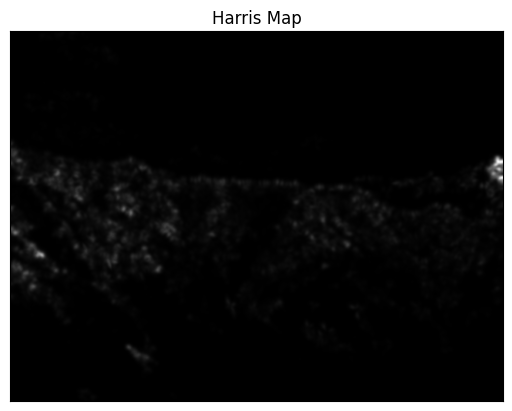

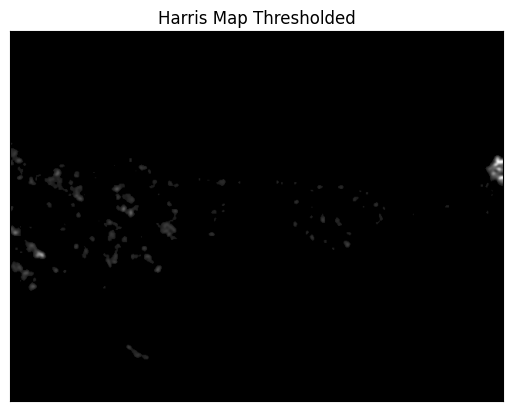

In [81]:
from skimage.feature import corner_peaks

im=readIm(get_image('yosemite7.jpg'),0)

#Compute Harris value at each pixel of the image.
[dx, dy] = derivatives(im, 1.5) # Compute derivatives

HMap = HarrisMap(dx,dy,2.25) # Compute Harris map

displayIm(HMap,"Harris Map",1)

# Thresholding to visualize the thresholded Harris map

HMap_thresholded = HMap

thresh = 600
for i in range(HMap.shape[0]):  # Loop through rows
    for j in range(HMap.shape[1]):  # Loop through columns
        # Check if the pixel value is below the threshold
        if HMap[i, j] < thresh:
            # Set the pixel value to zero
            HMap_thresholded[i, j] = 0
displayIm(HMap_thresholded, "Harris Map Thresholded",1)

# Non Maxima Suppression
[coord, values] = NonMaximaSuppression(HMap, 5, 600)

theta = orientation(dx,dy) # this is the Orientation for every point

# Get the orientations for the selected points from NonMaximaSuppression
orientations = []
for x, y in coord:
  # Ensure the coordinates are integers to index the arrays
  x_int, y_int = int(x), int(y)
  o = theta[x_int, y_int]
  orientations.append(o)

# Create the keypoints from coordinates, orientations, and scale = 3.
keypointlists = keyPoints(coord,orientations,scale=3)


Next, we want to draw circles around the keypoints with lines that go in the direction of its angle. the coordinates of the keypoints which will be the center of the circles are determined by the keypoint.pt attribute. A scale is defined which as was mentioned before is a constant and will be the radius of each circle. The keypoint.angle parameter reterns the orientation of each keypoint. In order to draw the line, we need to calculate the coordinates of the end point of each line. multiplying the radius by np.cos() and np.sin() of the angle computes the adjacent lines, which will give us the end points if they are added to the coordinates of the center.

Looking at the image, we see that the keypoints are more concentrated in the mountains and edges of the mountain which is suitable and what we expect from a corner detector algorithm.

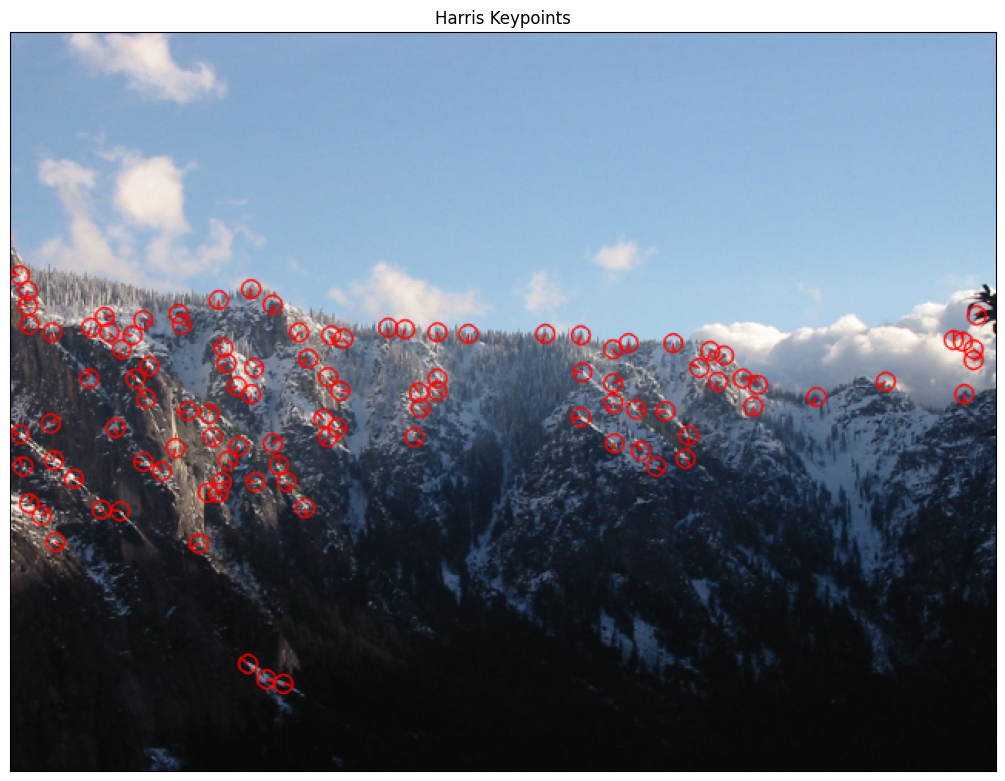

In [83]:
im=readIm(get_image('yosemite7.jpg'),1)

output_image = im.copy()

# Set the color for the circle (red) and line (green)

circle_color = (255, 0, 0)
line_color = (255, 0, 0)

# Looping through the keypoints to extract coordinates and angle in order to circle the keypoints.
for keypoints in keypointlists:

  y, x = int(keypoints.pt[0]), int(keypoints.pt[1])
  scale = 6 # Chose a bigger scale so the circles are bigger in the image
  angle = keypoints.angle

  # Convert the center coordinates to integers
  center = (int(x), int(y))

  # Draw the circle
  cv2.circle(output_image, center, scale, circle_color, 1, lineType=cv2.LINE_AA)

  # Calculate the endpoint for the line
  end_x = int(center[0] + scale * np.cos(np.radians(angle)))  # X coordinate
  end_y = int(center[1] + scale * np.sin(np.radians(angle)))  # Y coordinate
  end_point = (end_x, end_y)

  # Draw the line from center to the end point
  cv2.line(output_image, center, end_point, line_color, 1, lineType=cv2.LINE_AA)


displayIm(output_image, 'Harris Keypoints')

# <font color='blue'>**Exercise 3:** Matching keypoints between images using SIFT and Haralick descriptors (2 points)

<font color='blue'>Write the Python code necessary to compute the matching between points from two images. To do so, you have to apply the SIFT algorithm to both images in order to extract keypoints and descriptors (see https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html). Then, we use the Brute-Force cross-check criterion (`cv2.BFMatcher`) and Lowe's ratio distance criterion (`knnMatch`) to compute the matches and draw the best 100 matches using the function `cv2.drawMatches`.

In this exercise, we want to match the keypoints between the two images using SIFT descriptors.
The intuition behind SIFT is that we want to find maximum response in both position space and scale. Using normalized Laplacian applied in scale-spatial space, the responses are calculated. Apart from scale for each keypoint, SIFT also calculate the main orientation (by taking a square window around the detected feature, computing gradient direction for each pixel, creating a weighted direction histogram, and taking the peak in the histogram as the dominant direction). In the end each keypoint is made of x, y, scale, and orientation.

Apart from a detector, SIFT is also a descriptor which is one of its strengths. For each keypoint, a normalized patch around the keypoint (after rotation and scaling) is divided into 16x16 regions (4x4 cells). An 8bin weighted orientation histogram is calculated for each cell, which will give us the final descriptor : 16 cells* 8 orientations: 128 dimension descriptor.

SIFT can handle changes in viewpoint, illumination, translation, rotation and scale.

In this exercise we will use siftPoints function (consisting of cv2.SIFT_create() and .detectAndCompute() functions) to detect the keypoints and compute the descriptors for them. Here is a breakdown of what each part is supposed to be:

KeyPoints (kp): These are points of interest in the image.

Descriptors (ds): For each keypoint, SIFT also computes a descriptor that provides a unique fingerprint for the local image region around the keypoint. Descriptors allow us to match keypoints between different images.

In the context of this function, nfeatures is a parameter that specifies the number of best features to retain. The SIFT algorithm will find up to nfeatures keypoints that are considered the most important.

In [84]:
# this function computes KeyPoints and descriptors in an image using SIFT
def siftPoints(im,nfeatures=5000):
  sift = cv2.SIFT_create(nfeatures=nfeatures)
  kp, ds = sift.detectAndCompute(im, None)
  return kp,ds

Next function is showKP which uses drawKeypoints() to display the keypoints on the image.

Next, is the matching process. This function uses the descriptors of the keypoints in two images to find a match between them. This function has two modes: Brute-Force matching (BF) and K-Nearest Neighbors matching (KNN).
1. In Brute-Force matching, every descriptor in the first set (ds1) is compared with every descriptor in the second set (ds2) to find the closest matches. The comparison is based on a distance metric, which in this case is the L2 norm (Euclidean distance). The crossCheck=True parameter ensures that the matcher only retains those matches where the best match from ds1 matches the best match from ds2. This provides a symmetry that is considered a good initial filter for matches.
The matches are then sorted based on their distance, where a lower distance indicates a better match.
2. KNN matching finds the k best matches for each descriptor. In this function, k=2, which means for each descriptor in ds1, the two closest descriptors in ds2 are found.
These pairs are then filtered using Lowe's ratio test, which compares the distance of the closest match to the distance of the second-closest match. If the distance of the closest match is less than 75% of the second match, it is kept as a good match. This ratio test helps to remove ambiguous matches. The test is based on the observation that a good match between two features should have a significantly closer distance than the second-best match. By ensuring that the best match is a certain ratio closer than the second-best match, it filters out many incorrect matches.

After matching, we have showMatches, which takes the matches between the two image and the number of top matches (here N=100) and using cv2.drawMatches, we draw the best 100 matches. To do this, first, the matches were sorted using sorted() function, which sorts the matches based on a specified attribute of the element within that list. In the context of our problem, each match has a distance attribute that represents the similarity between the two features (keypoints) that have been matched. The smaller the distance, the more similar (and therefore better) the match is. The key parameter in the sorted() function specifies a function that will be called on each match object to determine the sort order. In this case, key=lambda x: x.distance is used, which takes x and returns x.distance.

In [48]:
# This function display the KeyPoints of an image
def showKP(im,kp,title):
  im=cv2.drawKeypoints(im, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  # Flag: the keypoints are drawn with their scale and the direction of the keypoint
  displayIm(im,title,1)

# This function display the matches between two images
def showMatches(im1,kp1,im2,kp2,matches, N, title='Matches'):
  # Sort matches and take the first N
  best_matches = sorted(matches, key=lambda x: x.distance)[:N]
  # smaller distance indicate stronger match
  imBF=cv2.drawMatches(im1, kp1, im2, kp2, best_matches, None, flags=2)
  displayIm(imBF,title,2)

#This function compute matches between descriptors of two images
def matching(ds1,ds2,FlagMode='BF'):
  if FlagMode=='BF':
    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2)
    # Match descriptors
    matches = bf.match(ds1, ds2)
    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

  elif FlagMode=='KNN':
    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2)
    # Apply KNN matching
    knn_matches = bf.knnMatch(ds1, ds2, k=2)
    # Ratio test, Lowe's ratio distance criterion
    good = [m for m, n in knn_matches if m.distance < 0.75 * n.distance]
    return good
  else:
    return print('Error in Matching mode')


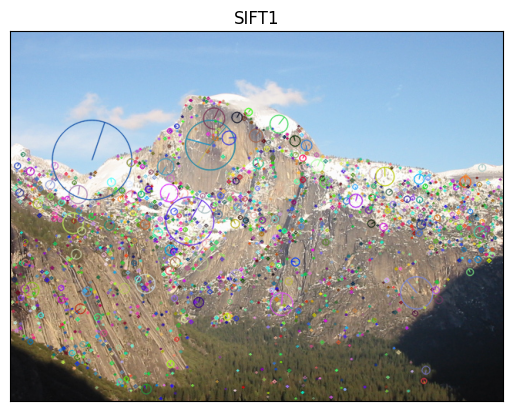

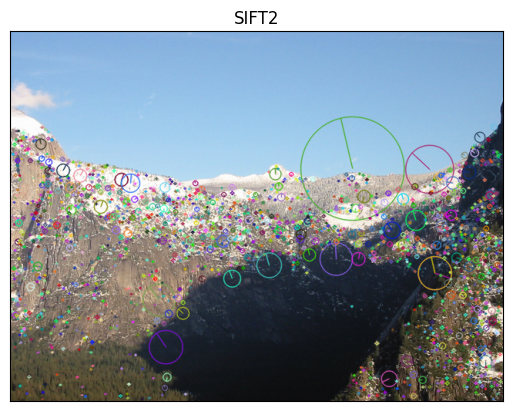

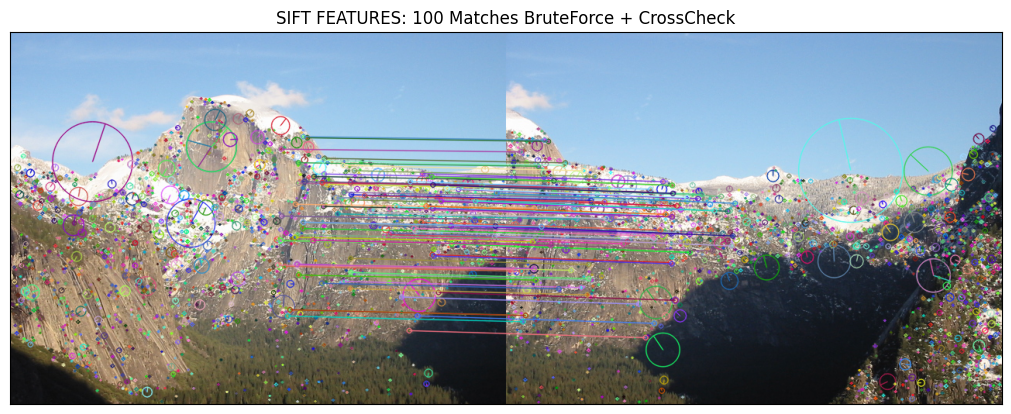

In [20]:
# Reading images, colored and greyscale
img1=readIm(get_image('yosemite2.jpg'),1)
im1=cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
img2=readIm(get_image('yosemite3.jpg'),1)
im2=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)

# Compute SIFT keypoints and descriptors for both images
kp1, ds1 = siftPoints(img1)
kp2, ds2 = siftPoints(img2)

# Match descriptors using Brute-Force
matches = matching(ds1, ds2, FlagMode='BF')

showKP(img1, kp1, "SIFT1")

showKP(img2, kp2, "SIFT2")

# Drawing the keypoints with their corresponding scale and orientation
img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_with_keypoints = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display the matches between the images
showMatches(img1_with_keypoints, kp1, img2_with_keypoints, kp2, matches, N=100, title='SIFT FEATURES: 100 Matches BruteForce + CrossCheck')

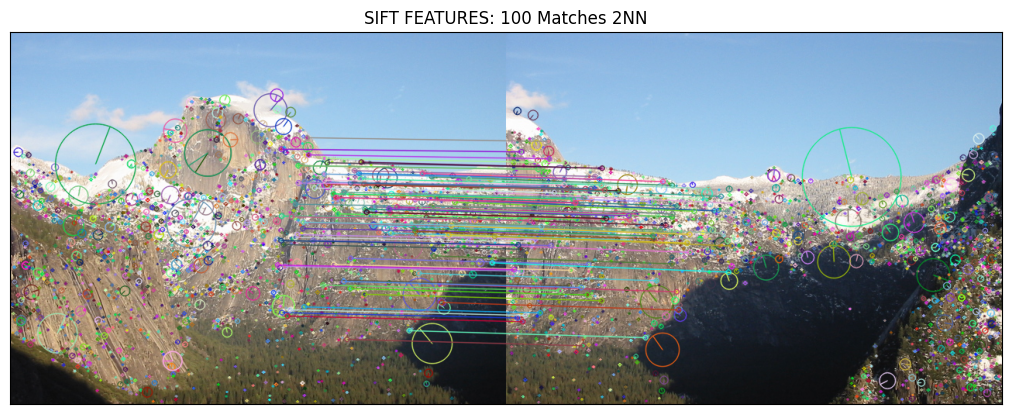

In [10]:
# Match descriptors using KNN
matches = matching(ds1, ds2, FlagMode='KNN')

# Display the matches between the images
showMatches(img1_with_keypoints, kp1, img2_with_keypoints, kp2, matches, N=100, title='SIFT FEATURES: 100 Matches 2NN')

<font color='blue'>Now, we have to perform exactly the same operation, but employing Haralick features. To do so, we are going to create a small window ($7\times7$ pixels) centered around the SIFT keypoint detected, and we are going to use `mahotas` library to compute those texture-based descriptors.

Haralick features are a set of texture descriptors derived from the co-occurrence matrix of an image. They are used in various tasks such as classification or segmentation. The co-occurrence matrix matrix is a matrix that holds the frequency of occurrence of pixel value pairs; meaning for instance, calculating how often a pixel with intensity a, occurs next to a pxiel with the intensity of b. Haralick features are calculated from this matrix, which are contrast, correlation, energy, homogeneity, etc. These features, provide a good description of the textural properties of an image.

In this section, we used the features.haralick() from the mahotas library to compute these features (they are around 13 values), in a 7x7 window around the keypoints that were detected by SIFT. Then the matching and showmatches functions from the previous section were used to match the features.

In [21]:
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 16.2 MB/s eta 0:00:00


In [22]:
import mahotas

def HaralickFeatures(im, keypoints, window = 7):
  features_list = []
  radius = window//2
  [M, N] = im.shape
  for kp in keypoints:
    i,j = int(kp.pt[0]), int(kp.pt[1])
    # Condition to make sure the window is within the image boundries
    if radius <= i < (M - radius) and radius <= j < (N - radius):
      subim = im[i-radius:i+radius+1, j-radius:j+radius+1] # 7x7 window
      features = mahotas.features.haralick(subim).mean(axis=0)
      features_list.append(features)

  return features_list

In [24]:
# Detecting keypoints with SIFT and calculating Haralick features

img1=readIm(get_image('yosemite2.jpg'),1)
img2=readIm(get_image('yosemite3.jpg'),1)

kp1, ds1 = siftPoints(img1)
kp2, ds2 = siftPoints(img2)

haralick1 = HaralickFeatures(im1, kp1)
haralick2 = HaralickFeatures(im2, kp2)

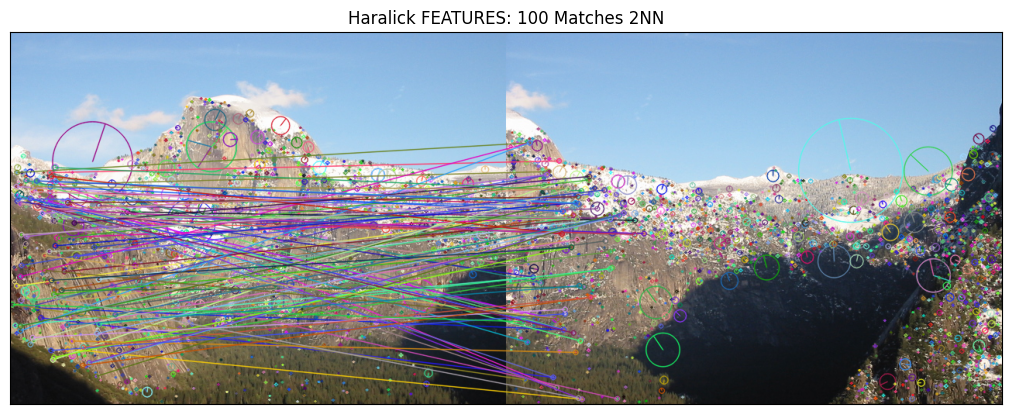

In [27]:
# Match descriptors using BruteForce
haralick1 = np.array(haralick1, dtype=np.float32) #bf.match(ds1, ds2) in matching function expects ds1 and ds2 to be NumPy arrays
haralick2 = np.array(haralick2, dtype=np.float32)

matches = matching(haralick1, haralick2, FlagMode='BF')

# Display the matches between the images
showMatches(img1_with_keypoints, kp1, img2_with_keypoints, kp2, matches, N=100, title='Haralick FEATURES: 100 Matches Brute-Force')

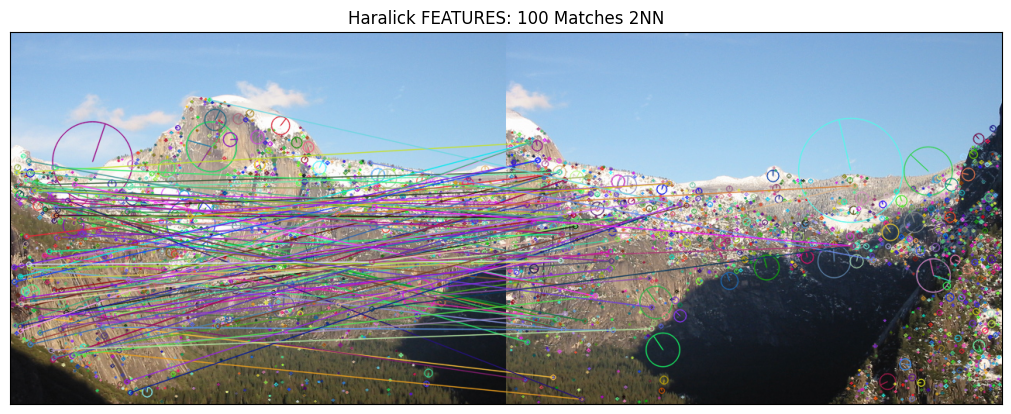

In [28]:
# Matching using KNN
matches = matching(haralick1, haralick2, FlagMode='KNN')

# Display the matches between the images
showMatches(img1_with_keypoints, kp1, img2_with_keypoints, kp2, matches, N=100, title='Haralick FEATURES: 100 Matches 2NN')

<font color='blue'> Which feature descriptor seems to be more suitable for keypoint matching? Why?

Looking at the results SIFT is doing significantly better than Haralick features (BruteForce or KNN).

Haralick features are generally not used for keypoint matching in the same way that algorithms like SIFT are used. Keypoint matching typically involves identifying specific points of interest in an image and creating descriptors that encapsulate local gradient information, which can be used to match keypoints between different images. In contrast, Haralick features are statistical descriptors of texture that are derived from the co-occurrence matrix of an image or a region within an image. They describe the texture of an area rather than individual points and are typically used for other tasks of texture characterization.

Haralick features lack the invariance or robustness that SIFT offers (to scale, rotation, translation, illumination, etc). Therefore, if the same texture appears at a different scale or orientation throughout the image, using Haralick features wouldn't be a suitable to differentiate between features and match them.

This image that we are using has very similar regions in terms of texture throughout the image that are also complex (mountains). Using this method, we will be matching different textures that statistically appear the same (have the same Haralick features). The Haralick descriptors for different regions in the two images are not distinct enough to be matched reliably. They might capture similar textural statistics between different parts of the images, resulting in incorrect matches.

Results indicate that choosing a suitable feature descriptor is important to have successful matching.



# <font color='blue'>**Exercise 4:** Image Stitching using Homographies (3 points)

<font color='blue'>Now we are going to compute homographies between images, and use them to build a mosaic/panorama. To calculate the homography between two images, call the function `cv2.findHomography()`, which takes as input the lists of KeyPoints and the matches found between them. Use RANSAC to perform a robust estimation.

In this exercise, we will be performing image stitching using Homographies. This is the process of combining multiple, partially overlapping images to create a panorama.

To create a panorama, we have to first detect the keypoints of the two images, using the detector we chose (here is SIFT). Then, we have to find the matching keypoints using the descriptors of the keypoints. Then, using the matched keypoints we have to estimate the homography (with the help of RANSAC to deal with the outliers).


**Homographies:**


Any two images of the same surface are related by a homography, which is a transformation (3x3 matrix) that allows
mapping points from one image onto the other. Homographies a.k.a projective transformations map one plane to another through a point; the same as taking an image through a poinhole from a scene. An important point about homographies is that they can represent not only rotations and translations (as affine transformations do) but also scaling and perspective transformations.

The important thing here for this assignment is if  images share the same center of projection (also called camera center - which here is the image in the center of canvas), we can map all images to a single plane by computing the homographies between the images.

For instance, when we have a homography that maps image 1 to 2 (H1), and another homography that maps image 2 to 3 (H2), we can find the homography that directly maps image 1 to 3 (H3) through matrix multiplication;

meaning H3 = H1*H2.

When we have point (p1) in image1, we can find corresponding poinr p2 in image2 with the help of H1 matrix:

p2 ~ H1 * p1 (points are in homogeneous coordinates).

The same goes for the points in image2 to image3: p3 ~ H2 * p2

Therefore, in order to map a point from image1 (p1) to image3 (p3) we will have:

p3 ~ H2 * (H1 * p1)

We can see that H3 can be simply computed as the multiplication of H1 and H2.

This concept applies when we want to calculate the homography between two images, and then between one image to the image in the center and later from each image to the canvas.

**Homography Function**

This function computes the homography, given two sets of keypoints, matches, RANSAC error, and a match count minimum.

MIN_MATCH_COUNT: A threshold for the minimum number of matches, which ensures that the computation of the homography is based on a sufficiently large set of points (grater than MIN_MATCH_COUNT). This helps to have a reliable homography.

Extracting Keypoint Locations (src_pts and dst_pts):
Source Points (src_pts): Coordinates of the matched keypoints in the first image. queryIdx is the index of the keypoint in the first image within the matches list. The same goes for Destination Points.
Both arrays are reshaped to meet the input requirements of cv2.findHomography, which expects floating-point numbers in a shape (-1, 1, 2). This shape represents a series of points, each with x and y coordinates.

Homography Calculation with RANSAC:

RANSAC (Random Sample Consensus) is used here to compute the homography matrix. It is an algorithm to estimate the parameters of a model from a set of observed data which contains outliers. It iteratively selects a random subset of the original data, estimates the homography, classifies all other data as inliers or outliers based on the Ransac_Error threshold, and then re-estimates the model using all inliers until the solution converges or achieves the best fit with the maximum number of inliers. Setting a lower error threshold makes the criteria for being considered an inlier stricter. A higher threshold is more lenient, allowing more matches to be considered as inliers


In [85]:
# this function computes a homography
def homography(kp1,kp2,matches, Ransac_Error, MIN_MATCH_COUNT=20):
  H = None
  # Match count check
  if len(matches)>MIN_MATCH_COUNT:
    # Extract location of matched keypoints in both images
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    # Computing the homography using RASAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, Ransac_Error)
  else:
     print('Error - very few matches')
  return H

<font color='blue'>To compose the mosaic we need to provide the following information:

> <font color='blue'>a) Maximum size of the canvas according to the number of images to be stitched and their dimensions.

> <font color='blue'>b) The central image that will give the axes to the mosaic.

> <font color='blue'>c) The order of each image with respect to the central one (i.e., we know the position of each image in the burst of images taken).

> <font color='blue'>d) The homography to copy the central image into the canvas.

<font color='blue'>Now, once all the aforementioned decisions have been made, we need to proceed as follows:
> <font color='blue'>a) Read the images from left to right.

> <font color='blue'>b) Set one central image as the reference to create the panorama. This one will provide the axes to the canvas.

> <font color='blue'>c) Compute the homography between each two consecutive images in your list.

> <font color='blue'>d) Set the canvas and the reference homography.

> <font color='blue'>e) Compute the homography between each image and the canvas.

> <font color='blue'>f) Use the computed homographies to transport the images to the canvas. Use the function `cv2. warpPerspective()`.

> <font color='blue'>g) Remove the black regions from the canvas to improve quality.



**computeLocalHomographies**

This function computes the homography between two consecutive images, taking the images, the method to match the images and the RANSAC error. We use the previous functions for feature detection and matching and also for computing the homography.





The central image's homography with respect to the canvas is an identity matrix because it's already positioned correctly on the canvas. The homographies of the other images to the canvas can be computed by chaining the local homographies appropriately.

In [86]:
# this function computes the homographies between each two consecutive images
def computeLocalHomographies(images,method='KNN', Ransac_Error=5.0):
  Hs = []

  # Feature detection and description using SIFT
  for i in range(len(images)-1): #Going through images, choosing each image and its next image
    kp1, des1 = siftPoints(images[i])
    kp2, des2 = siftPoints(images[i+1])
    # Matching
    matches = matching(des1, des2, FlagMode=method)
    # Computing the homography between two images
    H = homography(kp1, kp2, matches, Ransac_Error)
    if H is not None:
      Hs.append(H)
    else:
      Hs.append(None)
      print(f"Could not compute homography between images {i} and {i+1}")
  return Hs

# this function fixes the homography from the central image to the canvas
def axesHomography(sizeim,sizecanvas):
  H=np.eye(3)
  H[0,2]=sizecanvas[1]//2-sizeim[1]//2
  H[1,2]=sizecanvas[0]//2-sizeim[0]//2
  return H

**mosaicHomographies**

This function computes the homography from each image to the central image. As we said before, by having the homography of image pairs (image1 to image2, ..., image(idx-1) to image(idx)), we can compute the homography of each image to central image (idx).

For instance if H is a list of homography of pairs of images (H[0] transforms image0 to imag1), then the homography that transforms image0 to image(idx=5) is:

H[0] x H[1] x H[2] x H[3] x H[4]

This is what happens in the function for images to the left of the central image (we computed homographies from far left image to far right).

For images to the right of the central image, we have to inverse the H list, as it contains homographies of, for instance, image8 to image9, but we are interested in the homography of image9 to image8 as we are moving from the far-right image to the central image. In this sense, then the homography that transforms image8 to image(idx=5) is:

invH[7] x invH[6] x invH[5]

which is implemented in the function.

In [95]:
# This function computes the homography from each image to the central image

def mosaicHomographies(H, idx):
    n = len(H) + 1  # Total number of images, 14
    H_to_middle = [None] * n

    # Homography for the central image to itself is the identity matrix
    H_to_middle[idx] = np.eye(3)

    # Compute homographies for images on the left side of the central image
    for i in range(idx - 1, -1, -1):
        if i == idx - 1: # The image next to central image
            H_to_middle[i] = H[i]  # Direct homography to the central image, which we already have in H
        else:
            H_to_middle[i] = H[i] @ H_to_middle[i + 1]  # Accumulate homographies towards the center

    # Compute homographies for images on the right side of the central image
    for i in range(idx + 1, n):
        if i == idx + 1: # The image next to central image
            H_to_middle[i] = np.linalg.inv(H[i - 1])  # Inverse of the homography just right of the center, which we already have in H
        else:
            H_to_middle[i] = np.linalg.inv(H[i - 1]) @ H_to_middle[i - 1]  # Accumulate inverse homographies towards the center

    return H_to_middle


In [67]:
# Auxiliary functions

# this function defines and return the canvas
def setCanvas(rows,cols,flagColor=True,nim=2): #rows and cols of the image
  if flagColor: # we have 14 images, therefore the max width would be 14*cols
    canvas = np.zeros((rows * nim, cols * 14, 3), np.uint8) #14 images
  else:
    canvas = np.zeros((rows * nim, cols * 14), np.uint8)
  return canvas

# This function removes the redundant pixels from the canvas
def blackOut(img, offset=0):
  if len(img.shape)==3:
    im =cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = np.array((im > 0), np.uint8)
    x,y,w,h=cv2.boundingRect(mask)
    return img[y+offset:y+h-offset,x+offset:x+w-offset,:]
  else:
    mask = np.array((img > 0), np.uint8)
    x,y,w,h=cv2.boundingRect(mask)
    return img[y+offset:y+h-offset,x+offset:x+w-offset]



**composeMosaic**

The function composeMosaic takes as input the set of images, the canvas, the set of homographies that map each image to a central image, and the transformation matrix (H0) that maps the central image onto the canvas. The goal is to use these inputs to create a single mosaic image where all images are correctly positioned relative to each other on the canvas.

First, we warp the central image using cv2.warpPerspective() using, the central image, H0, dimensions of the canvas, and flags related to controlling the interpolation and handling the borders during warping.

Then we do the same for other images, however, H contains the transformation of each image to the central image; therefore we need to first compute the homography from each image to the canvas by:

H_tocenter = H0 x H[i]

Then, again using cv2.warpPerspective(), images are transformed into the canvas one by one and he panorama is formed.

In [68]:
# this function composes the mosaic
def composeMosaic(images,canvas,H,idxc,H0):
  rows, cols = canvas.shape[0], canvas.shape[1]
  H_tocenter = []

  # Warp the central image using H0 and place it on the canvas
  canvas = cv2.warpPerspective(images[idxc], H0, (cols, rows), dst=canvas, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_TRANSPARENT)

  # Iterate over all images to project them into the canvas
  for i, image in enumerate(images):
    if i != idxc:
      H_tocenter = H0 @ H[i] # For images before the central #H_left2canvas = H0 * H_left2center
      canvas = cv2.warpPerspective(image, H_tocenter, (cols, rows), dst=canvas, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_TRANSPARENT)

  displayIm(blackOut(canvas),'Mosaic',2) #this blackOut removes the excess black space
  return canvas

In [97]:
images=[]
#Mosaic construction: Left-Right camera motion

PREFIX='IMG_20211030_1104'
DIR=''
nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']

for item in nameImages:
  images.append(readIm(get_image(PREFIX+item),flagColor=1))

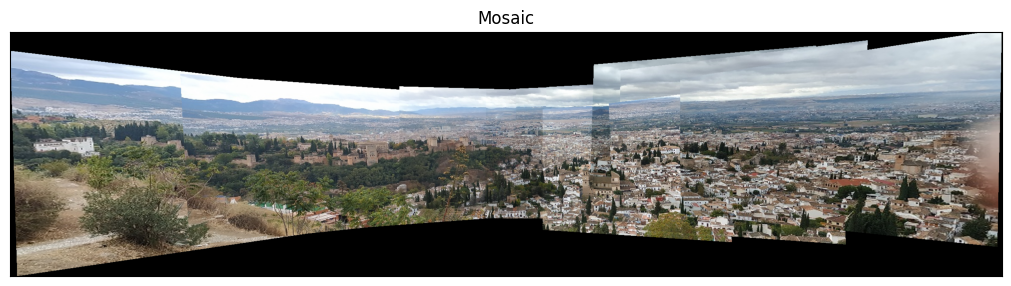

In [98]:
H = computeLocalHomographies(images,method='KNN', Ransac_Error=5) # between consecutive images
imheight, imwidth = images[0].shape[:2]
canvas=setCanvas(imheight, imwidth, flagColor=True, nim=2)
sizeim = images[0].shape[:2]  # shape of the image
sizecanvas = (canvas.shape[0], canvas.shape[1]) # shape of the canvas
H0 = axesHomography(sizeim,sizecanvas)
mosaicH = mosaicHomographies(H, 5) # index of central image = 5, 6th image
mosaic= composeMosaic(images, canvas, mosaicH,5, H0)